In [1]:
%pip install factorgraph
%pip install networkx

import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import factorgraph as fg
import pickle
import copy

  Preparing metadata (setup.py) ... done
  Created wheel for factorgraph: filename=factorgraph-0.0.3-py3-none-any.whl size=11436 sha256=68962b13438398b07d3a3bdd51e25a1e7176a8ac3a9f4c6e7d4777748bf157f7
  Stored in directory: /root/.cache/pip/wheels/fe/98/f9/c4d776af3fae6e5153ae2aa199166aa641a857dd18bf1b2aad
Successfully built factorgraph


# Examples


In [2]:
# @title Example 2 and 3 Lib
def generate_combination_df(num_nodes):
  combinations = list(itertools.product([-1, 1], repeat=num_nodes))
  df = pd.DataFrame(combinations, columns=[f"v{i+1}" for i in range(num_nodes)])
  return df

def compute_marginals(J, connections, df):
  marginals = []
  for index, row in df.iterrows():
    s = 0
    for i in range(10):
      for j in range(i, 10):
        if (j + 1) in connections[i + 1]:
          s += row.iloc[i] * row.iloc[j]
    marginals.append(np.exp(J * s))
  return np.array(marginals) / sum(marginals)

def compute_expected_agreement_rate(df, J):
  assert np.abs(df['prob_' + str(J)].sum() - 1) < 0.0001
  return (df['prob_' + str(J)] * df['agreement_rate']).sum()

def compute_marginals_for_all(df, J_range, connections):
  for J in J_range:
    df['prob_'+str(J)] = compute_marginals(J, connections, df)
  return df

def compute_agreement_rate(df):
  df['agreement_rate'] = (df.iloc[:,0:10].sum(axis=1)+10)/ 2 / 10
  return df

def find_best_consultant(df, J_range):
  agreement_dict = {}
  for J in J_range:
    expected_agreement_rates = []
    for i in range(10):
      df_sub = df[df.iloc[:, i] == 1]
      expected_agreement_rate = (df_sub['prob_' + str(J)] * df_sub['agreement_rate']).sum() / df_sub['prob_' + str(J)].sum()

      expected_agreement_rates.append(expected_agreement_rate)
    agreement_dict[J] = expected_agreement_rates
    best_consultant = np.argmax(expected_agreement_rates) + 1
    print("Best consultant for J=%.2f is %i" %(J, best_consultant))
  return agreement_dict

def show_marginal_given_consultants(df, consultants, J_range, observed_nodes):
  """
  consultant: int. Consultant index from 1-10.
  """
  for consultant in consultants:
    df_sub = df[df.iloc[:, consultant - 1] == 1]
    results_dict = {}
    for n in observed_nodes:
      if n == consultant:
        continue
      marginals = []
      for j in J_range:
        marginal = df_sub[df_sub['v'+str(n)]==1]['prob_' + str(j)].sum() / 0.5
        marginals.append(marginal)
      results_dict[n] = marginals

    for n in observed_nodes:
      if n == consultant:
        continue
      if consultant == consultants[1]:
        plt.scatter(J_range, results_dict[n], label=('v%s|v%s' %(str(n), str(consultant))), marker='o')
      else:
        plt.plot(J_range, results_dict[n], label=('v%s|v%s' %(str(n), str(consultant))))
  plt.legend()
  plt.title("Marginal probability of agreement given v_consultant=1")
  plt.xlabel("J^")
  plt.ylabel("P(vi=1|v_consultant=1)")
  plt.show()


def compute_degree_centrality_center(connections):
    center = max(connections, key=lambda k: len(connections[k]))
    return center

from collections import deque

def compute_closeness_centrality(connections):
    def bfs_shortest_paths(start, graph):
        distances = {node: float('inf') for node in graph}
        distances[start] = 0
        queue = deque([start])

        while queue:
            current = queue.popleft()
            for neighbor in graph[current]:
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

        return distances

    centrality = {}
    for node in connections:
        distances = bfs_shortest_paths(node, connections)
        reachable_nodes = sum(1 for d in distances.values() if d < float('inf'))
        if reachable_nodes > 1:  # Avoid division by zero
            centrality[node] = (reachable_nodes - 1) / sum(d for d in distances.values() if d < float('inf'))
        else:
            centrality[node] = 0

    # Find the node with the highest closeness centrality
    center_node = max(centrality, key=centrality.get)
    return center_node, centrality[center_node]


def compute_betweenness_centrality(connections):
    def bfs_paths_count(start, graph):
        # BFS to calculate shortest paths and the number of shortest paths passing through each node
        queue = deque([start])
        distances = {node: float('inf') for node in graph}
        shortest_paths = {node: 0 for node in graph}
        predecessors = {node: [] for node in graph}

        distances[start] = 0
        shortest_paths[start] = 1

        while queue:
            current = queue.popleft()
            for neighbor in graph[current]:
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)
                if distances[neighbor] == distances[current] + 1:
                    shortest_paths[neighbor] += shortest_paths[current]
                    predecessors[neighbor].append(current)

        return distances, shortest_paths, predecessors

    centrality = {node: 0 for node in connections}
    for source in connections:
        distances, shortest_paths, predecessors = bfs_paths_count(source, connections)
        dependency = {node: 0 for node in connections}

        nodes = sorted(connections, key=lambda x: distances[x], reverse=True)
        for node in nodes:
            for predecessor in predecessors[node]:
                ratio = shortest_paths[predecessor] / shortest_paths[node]
                dependency[predecessor] += ratio * (1 + dependency[node])
            if node != source:
                centrality[node] += dependency[node]

    # Normalize centrality values
    factor = 1 / ((len(connections) - 1) * (len(connections) - 2)) if len(connections) > 2 else 1
    for node in centrality:
        centrality[node] *= factor

    center_node = max(centrality, key=centrality.get)
    return center_node, centrality[center_node]

def compute_bonacich_centrality(connections, alpha=0.01, beta=1.0, max_iter=100, tol=1e-6):
    nodes = list(connections.keys())
    n = len(nodes)
    adjacency_matrix = np.zeros((n, n))
    node_index = {node: i for i, node in enumerate(nodes)}

    for node, neighbors in connections.items():
        for neighbor in neighbors:
            adjacency_matrix[node_index[node], node_index[neighbor]] = 1

    centrality = np.ones(n)
    for _ in range(max_iter):
        new_centrality = alpha * adjacency_matrix.dot(centrality) + beta
        if np.linalg.norm(new_centrality - centrality) < tol:
            break
        centrality = new_centrality

    centrality_dict = {nodes[i]: centrality[i] for i in range(n)}
    center_node = max(centrality_dict, key=centrality_dict.get)
    return center_node, centrality_dict[center_node]

def compute_centrality(connections):
  # @title Compute centrality
  degree_center = compute_degree_centrality_center(connections)
  print("Degree centrality center is %i" %degree_center)

  center, centrality_value = compute_closeness_centrality(connections)
  print(f"Center Node: {center}, Closeness Centrality: {centrality_value}")


  center_betweenness, betweenness_value = compute_betweenness_centrality(connections)
  print(f"Betweenness Centrality - Center Node: {center_betweenness}, Value: {betweenness_value}")

  center_bonacich, bonacich_value = compute_bonacich_centrality(connections)
  print(f"Bonacich Centrality - Center Node: {center_bonacich}, Value: {bonacich_value}")
  return degree_center, center, center_betweenness, center_bonacich

In [3]:
# @title Example 2

e2a_connections = {1:[2],
               2:[1, 3, 4],
               3:[1, 2, 5],
               4:[2],
               5:[3]}

e2b_connections = {1:[2, 3],
               2:[1, 3, 4],
               3:[2, 5],
               4:[2],
               5:[3]}

print("centrality for example 2a)")
compute_centrality(e2a_connections)
print("centrality for example 2b)")
compute_centrality(e2b_connections)

centrality for example 2a)
Degree centrality center is 2
Center Node: 2, Closeness Centrality: 0.8
Betweenness Centrality - Center Node: 2, Value: 0.6666666666666666
Bonacich Centrality - Center Node: 2, Value: 1.030511
centrality for example 2b)
Degree centrality center is 2
Center Node: 2, Closeness Centrality: 0.8
Betweenness Centrality - Center Node: 2, Value: 0.6666666666666666
Bonacich Centrality - Center Node: 2, Value: 1.030512


(2, 2, 2, 2)

Best consultant for J=0.05 is 2
Best consultant for J=0.10 is 2
Best consultant for J=0.20 is 2
Best consultant for J=0.30 is 2
Best consultant for J=0.40 is 2
Best consultant for J=0.50 is 2
Best consultant for J=0.80 is 2
Best consultant for J=1.00 is 3
Best consultant for J=1.25 is 3
Best consultant for J=1.50 is 3
Best consultant for J=2.00 is 3


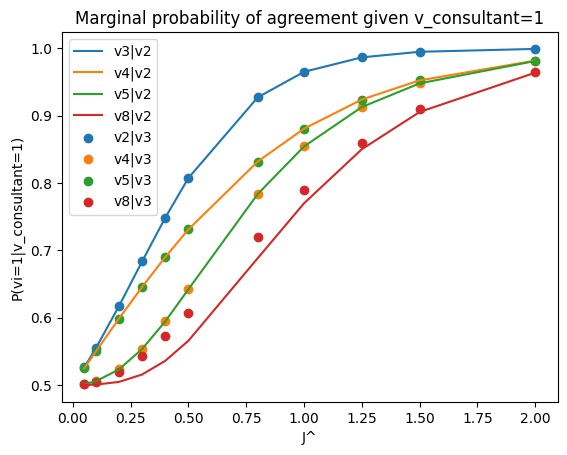

In [4]:
# @title Example 3

connections = {1:[2, 3],
               2:[1, 3, 4, 6, 7],
               3:[1, 2, 5],
               4:[2],
               5:[3, 8, 9, 10],
               6:[2],
               7:[2],
               8:[5],
               9:[5],
               10:[5]}
J_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0, 1.25, 1.5, 2.0]

df = generate_combination_df(10)
df = compute_agreement_rate(df)
df = compute_marginals_for_all(df, J_range, connections)
agreement_dict = find_best_consultant(df, J_range)
show_marginal_given_consultants(df, [2,3], J_range, [2, 3, 4, 5, 8])

In [5]:
# @title Compute centrality
degree_center = compute_degree_centrality_center(connections)
print("Degree centrality center is %i" %degree_center)

center, centrality_value = compute_closeness_centrality(connections)
print(f"Center Node: {center}, Closeness Centrality: {centrality_value}")


center_betweenness, betweenness_value = compute_betweenness_centrality(connections)
print(f"Betweenness Centrality - Center Node: {center_betweenness}, Value: {betweenness_value}")

center_bonacich, bonacich_value = compute_bonacich_centrality(connections)
print(f"Bonacich Centrality - Center Node: {center_bonacich}, Value: {bonacich_value}")

Degree centrality center is 2
Center Node: 3, Closeness Centrality: 0.6
Betweenness Centrality - Center Node: 2, Value: 0.5833333333333333
Bonacich Centrality - Center Node: 2, Value: 1.05083465


In [6]:
# @title 2/3 and 90% agreement rate
J = [1.0] # or [0.05]
consultants = []
agreement_rate = 0.5
target_agreement_rate = 0.67 # or 0.90
df_sub = df.copy()
while agreement_rate < target_agreement_rate:
  agreement_dict = find_best_consultant(df_sub, J)
  best_consultant = np.argmax(agreement_dict[J[0]]) + 1

  consultants.append(best_consultant)

  df_sub = df_sub[df_sub.iloc[:, best_consultant - 1] == 1]
  df_sub['prob_'+str(J[0])] = df_sub['prob_'+str(J[0])] / df_sub['prob_'+str(J[0])].sum()
  agreement_rate = compute_expected_agreement_rate(df_sub, J[0])

  print("Adding consultant %i, current agreement rate is %f" %(best_consultant, agreement_rate))

Best consultant for J=1.00 is 3
Adding consultant 3, current agreement rate is 0.874444


# Real-world Applications

In [7]:
# @title Real-world Application Lib
def load_nxnetwork(path):
# Load the pickle file
  with open(file_path, 'rb') as f:
    nx_network = pickle.load(f)
  largest_cc = max(nx.connected_components(nx_network), key=len)

  to_remove = []

  for node in nx_network.nodes:
    if node not in largest_cc:
      to_remove.append(node)

  for node in to_remove:
      nx_network.remove_node(node)
  return nx_network

def draw_network_preview(nx_network, size=200):
  pos = nx.drawing.spring_layout(nx_network)
  plt.clf()
  plt.figure(figsize=(20, 10))
  nx.draw(nx_network, pos, node_size=size)
  plt.show()

max_consultants = 50

def build_graph_from_networkx(networkx_graph, J):
  g = fg.Graph()

  for node in networkx_graph.nodes:
    g.rv(str(node), 2)

  for edge in networkx_graph.edges:
    g.factor([str(edge[0]), str(edge[1])], potential=np.array([
          [np.exp(J), np.exp(-J)],
          [np.exp(-J), np.exp(J)],
  ]))
  return g

def compute_agreement_rate_from_marginals(marginals):
  expected_agreement = 0
  for index, array in marginals:
    expected_agreement += array[1]
  return expected_agreement / len(marginals)

def find_best_consultant_from_fg_graph(fg_graph, consultants_dict = {}):
  agreements = {}

  for node, _ in fg_graph._rvs.items():
    if node in consultants_dict:
      continue
    g = copy.deepcopy(fg_graph)
    g.factor([str(node)], potential=np.array([0.0, 1.0]))

    iters, converged = g.lbp(normalize=True)
    marginals = g.rv_marginals(normalize=True)
    agreement_rate = compute_agreement_rate_from_marginals(marginals)
    print('LBP ran for %d iterations. Converged = %r' % (iters, converged))
    print(node)
    print(agreement_rate)
    print(marginals)
    print('-----------------')
    agreements[node] = agreement_rate

  if len(agreements) == 0:
    return "-1"
  best_consultant = max(agreements, key=agreements.get)
  print("best consultant is %s" %best_consultant)
  return best_consultant

def consultants_for_desired_agreement(desired_agreement, fg_graph):
  consultants = []
  current_agreement = 0
  consultant_dict = {}

  g = copy.deepcopy(fg_graph)
  while current_agreement < desired_agreement:
    best_consultant = find_best_consultant_from_fg_graph(g, consultant_dict)
    consultant_dict[best_consultant] = 1

    # print(g._factors)
    # print('-------')

    g.factor([best_consultant], potential=np.array([0.0, 1.0]))
    iters, converged = g.lbp(normalize=True)
    marginals = g.rv_marginals(normalize=True)
    agreement_rate = compute_agreement_rate_from_marginals(marginals)

    print('Consultant += ', best_consultant)
    print('Current agreement = ', agreement_rate)

    current_agreement = agreement_rate
    consultants.append(best_consultant)

  return consultants

def consultants_info_gain(fg_graph):
  consultants = []
  agreements = []
  consultant_dict = {}

  g = copy.deepcopy(fg_graph)
  while True:
    best_consultant = find_best_consultant_from_fg_graph(g, consultant_dict)

    if best_consultant == "-1":
      break

    consultant_dict[best_consultant] = 1

    g.factor([best_consultant], potential=np.array([0.0, 1.0]))
    iters, converged = g.lbp(normalize=True)
    marginals = g.rv_marginals(normalize=True)
    agreement_rate = compute_agreement_rate_from_marginals(marginals)

    agreements.append(agreement_rate)
    consultants.append(best_consultant)

  return agreements

def draw_consultants(nx_network, consultants):
  color_map = []
  for node in nx_network.nodes:
    if node in consultants or str(node) in consultants:
      color_map.append('red')
    else:
      color_map.append('green')
  pos = nx.drawing.spring_layout(nx_network)
  plt.clf()
  plt.figure(figsize=(20, 10))
  nx.draw(nx_network, pos, node_color=color_map, node_size=220)
  plt.show()

def plot_info_gain(agreements, title):
  plt.plot(range(1, len(agreements) + 1), agreements)
  plt.xticks(np.arange(1, len(agreements), step=2))
  plt.title('Agreement Rate vs. Number of Agreed Consultants, %s' %title)
  plt.xlabel('Number of Agreed Consultants')
  plt.ylabel('Expected Agreement Rate')
  plt.show()

def get_holistic_nx_graph():
  with open('General Relativity and Quantum Cosmology collaboration network.txt', 'r') as f:
    lines = f.readlines()

  edges = {}
  nodes = set()
  for line in lines:
    if line[0] == '#':
      continue
    start = int(line.split('\t')[0])
    end = int(line.split('\t')[1].split('\n')[0])
    nodes.add(start)
    nodes.add(end)

    if start in edges:
      edges[start].append(end)
    else:
      edges[start] = [end]

  g = nx.Graph()
  g.add_nodes_from(nodes)

  for s, es in edges.items():
    for e in es:
      g.add_edge(s, e)
  return g, edges


def sample_subgraph(g, edges):
  CCs = list(reversed(sorted(nx.connected_components(g), key=len)))
  largest_cc = CCs[0]
  np.random.seed(1312)
  size_limit = 60

  select_nodes = [np.random.choice(list(largest_cc), size=1)[0]]

  for node in largest_cc:
    for e in edges[node]:
      select_nodes.append(e)
      if len(select_nodes) > size_limit:
        break
    if len(select_nodes) > size_limit:
      break

  g_sub_original = g.subgraph(select_nodes).copy()

  # Sample subgraph
  np.random.seed(1314)

  g_sub_cc = max(nx.connected_components(g_sub_original), key=len)
  g_sub = g.subgraph(g_sub_cc).copy()

  second_keep_rate = 0.2
  for u, v in g_sub.edges():
    if np.random.random() >= second_keep_rate:
      droped_graph = g_sub.copy()
      droped_graph.remove_edge(u, v)
      if len(list(nx.connected_components(droped_graph))) == 1:
        g_sub.remove_edge(u, v)

  return g_sub


## Application. GR-QC Network with Tight Connections



/usr/local/lib/python3.11/dist-packages/factorgraph/factorgraph.py:86: RuntimeWarning: invalid value encountered in divide
  c = a / b


LBP ran for 8 iterations. Converged = np.True_
21379
0.6744701490656588
[(21379, array([0., 1.])), (11015, array([0.3859601, 0.6140399])), (17289, array([0.15446527, 0.84553473])), (9993, array([0.26121149, 0.73878851])), (23051, array([0.15446527, 0.84553473])), (20116, array([0.15446527, 0.84553473])), (15126, array([0.44553716, 0.55446284])), (16414, array([0.33498055, 0.66501945])), (21281, array([0.26121149, 0.73878851])), (25379, array([0.42119051, 0.57880949])), (17828, array([0.44553716, 0.55446284])), (21165, array([0.42119051, 0.57880949])), (3502, array([0.42119051, 0.57880949])), (1839, array([0.33498055, 0.66501945])), (17330, array([0.33498055, 0.66501945])), (25910, array([0.33498055, 0.66501945])), (23864, array([0.3859601, 0.6140399])), (1339, array([0.33498055, 0.66501945])), (8768, array([0.33498055, 0.66501945])), (23038, array([0.15446527, 0.84553473])), (22476, array([0.3859601, 0.6140399])), (9937, array([0.26121149, 0.73878851])), (16210, array([0.44553716, 0.55

<Figure size 640x480 with 0 Axes>

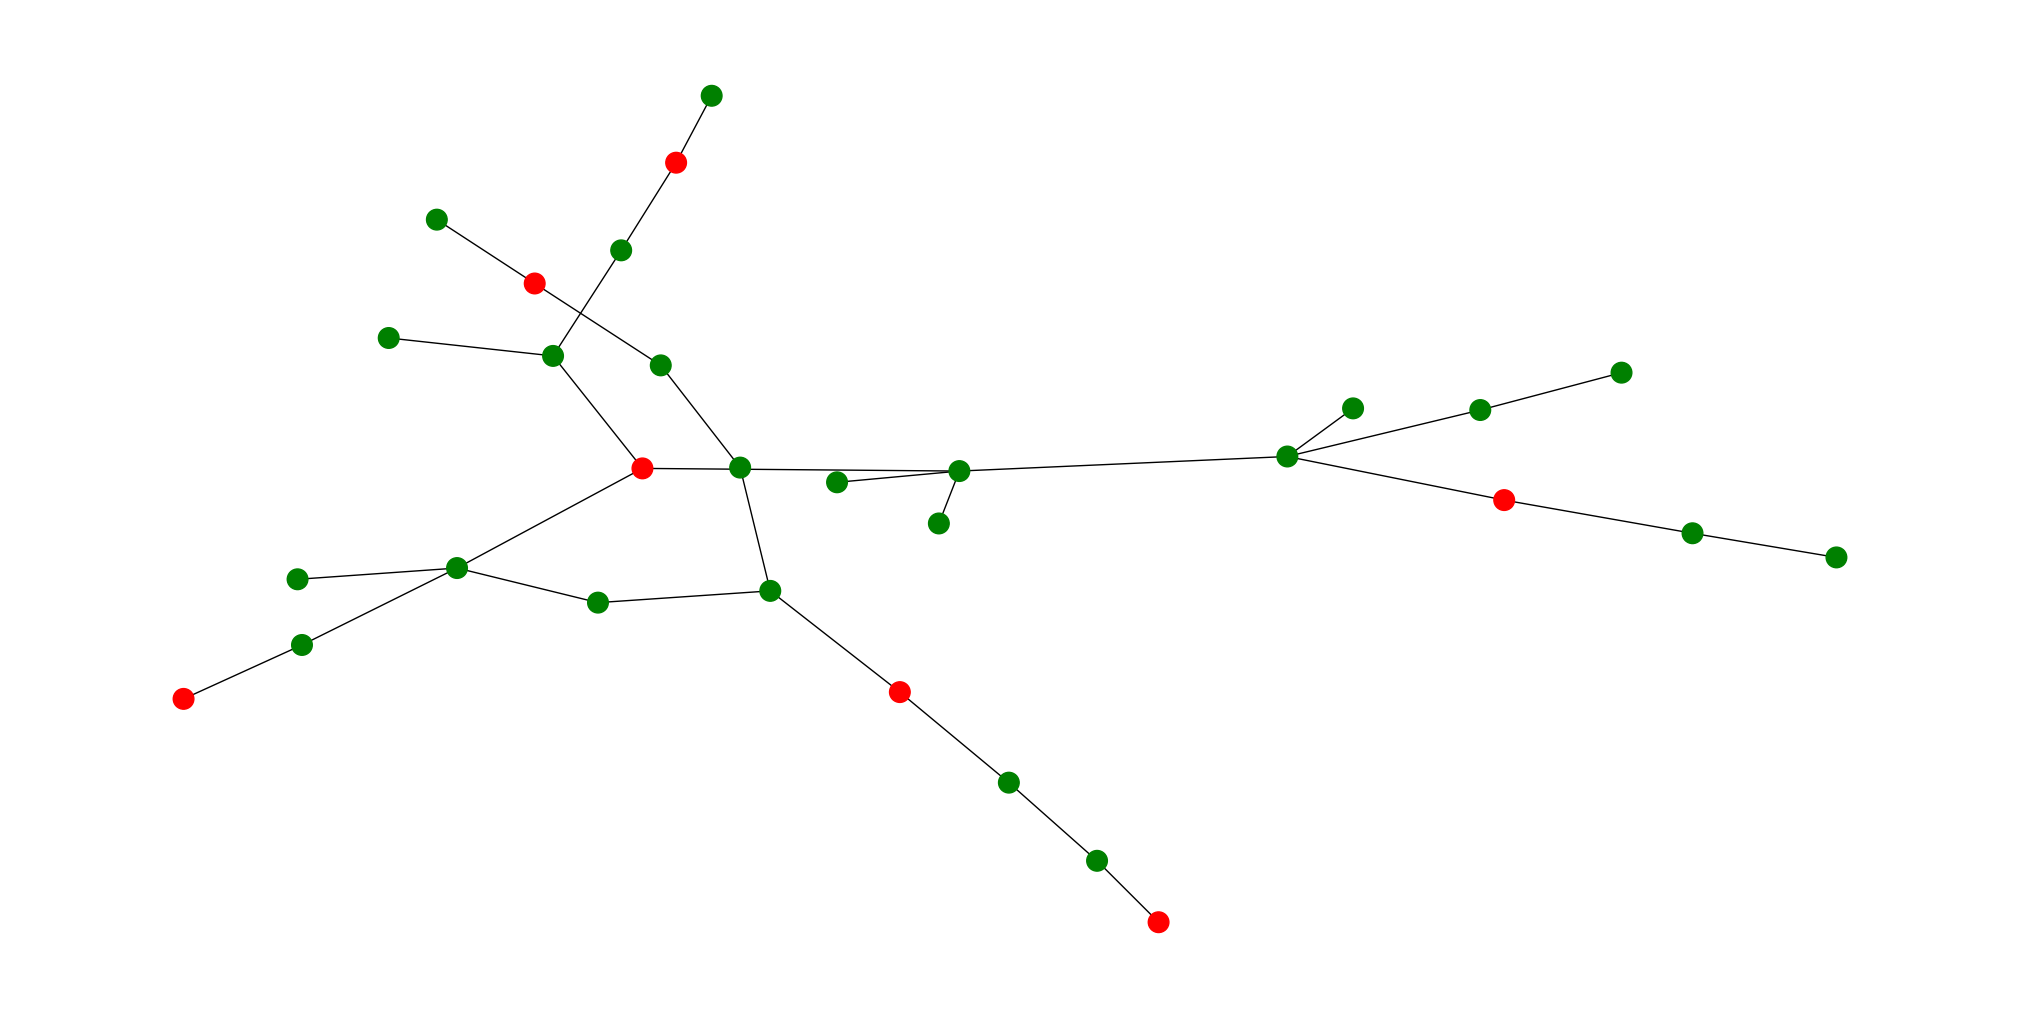

In [8]:
# @title Application consultants identification
g, edges = get_holistic_nx_graph()
g_sub = sample_subgraph(g, edges)
# draw_network_preview(g_sub)

desired_agreement = 0.9
J = 0.85
fg_graph = build_graph_from_networkx(g_sub, J)
consultants = consultants_for_desired_agreement(desired_agreement, fg_graph)

draw_consultants(g_sub, consultants)

LBP ran for 8 iterations. Converged = np.True_
21379
0.6744701490656588
[(21379, array([0., 1.])), (11015, array([0.3859601, 0.6140399])), (17289, array([0.15446527, 0.84553473])), (9993, array([0.26121149, 0.73878851])), (23051, array([0.15446527, 0.84553473])), (20116, array([0.15446527, 0.84553473])), (15126, array([0.44553716, 0.55446284])), (16414, array([0.33498055, 0.66501945])), (21281, array([0.26121149, 0.73878851])), (25379, array([0.42119051, 0.57880949])), (17828, array([0.44553716, 0.55446284])), (21165, array([0.42119051, 0.57880949])), (3502, array([0.42119051, 0.57880949])), (1839, array([0.33498055, 0.66501945])), (17330, array([0.33498055, 0.66501945])), (25910, array([0.33498055, 0.66501945])), (23864, array([0.3859601, 0.6140399])), (1339, array([0.33498055, 0.66501945])), (8768, array([0.33498055, 0.66501945])), (23038, array([0.15446527, 0.84553473])), (22476, array([0.3859601, 0.6140399])), (9937, array([0.26121149, 0.73878851])), (16210, array([0.44553716, 0.55

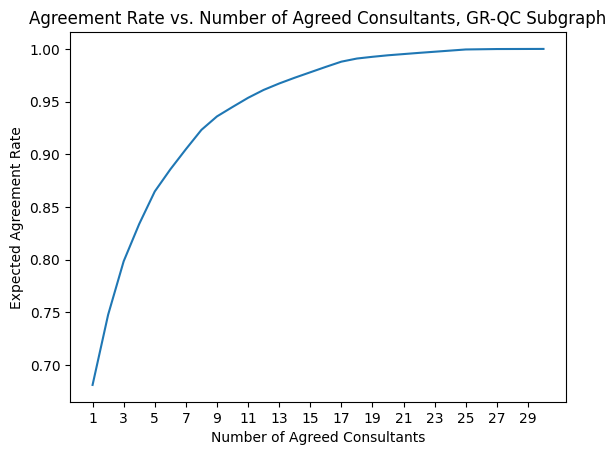

In [9]:
# @title Application Info Gain
agreements_85 = consultants_info_gain(fg_graph)
plot_info_gain(agreements_85, title='GR-QC Subgraph')

In [10]:
J = 0.2
fg_graph = build_graph_from_networkx(g_sub, J)
agreements_20 = consultants_info_gain(fg_graph)

LBP ran for 8 iterations. Converged = np.True_
21379
0.5334989070298638
[(21379, array([0., 1.])), (11015, array([0.49924118, 0.50075882])), (17289, array([0.40131234, 0.59868766])), (9993, array([0.48052149, 0.51947851])), (23051, array([0.40131234, 0.59868766])), (20116, array([0.40131234, 0.59868766])), (15126, array([0.49997044, 0.50002956])), (16414, array([0.49615542, 0.50384458])), (21281, array([0.48052149, 0.51947851])), (25379, array([0.49985023, 0.50014977])), (17828, array([0.49997044, 0.50002956])), (21165, array([0.49985023, 0.50014977])), (3502, array([0.49985023, 0.50014977])), (1839, array([0.49615542, 0.50384458])), (17330, array([0.49615542, 0.50384458])), (25910, array([0.49615542, 0.50384458])), (23864, array([0.49924118, 0.50075882])), (1339, array([0.49615542, 0.50384458])), (8768, array([0.49615542, 0.50384458])), (23038, array([0.40131234, 0.59868766])), (22476, array([0.49924118, 0.50075882])), (9937, array([0.48052149, 0.51947851])), (16210, array([0.49997044

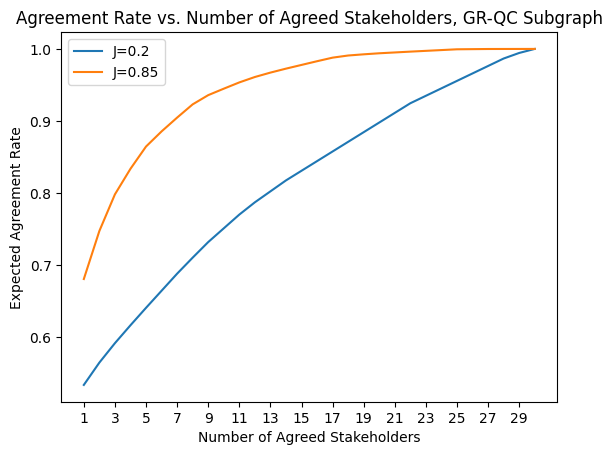

In [11]:
plt.plot(range(1, len(agreements_20) + 1), agreements_20, label='J=0.2')
plt.plot(range(1, len(agreements_85) + 1), agreements_85, label='J=0.85')
plt.xticks(np.arange(1, len(agreements_85), step=2))
plt.title('Agreement Rate vs. Number of Agreed Stakeholders, GR-QC Subgraph')
plt.xlabel('Number of Agreed Stakeholders')
plt.ylabel('Expected Agreement Rate')
plt.legend()
plt.show()